# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn.functional as F 

from tqdm.notebook import tqdm
import utils

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load MNIST Handwritten Dataset

In [2]:
from torchvision import datasets 
from torchvision import transforms as T

In [3]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.ToTensor(), # (h, w, c) -> (c, h, w)
    T.Normalize(mean = 0.5, std = 0.5)
])

valid_augs = T.Compose([
    T.ToTensor(),
    T.Normalize(mean = 0.5, std = 0.5)
])

In [4]:
trainset = datasets.MNIST('./', download = False, train = True, transform = train_augs)
testset = datasets.MNIST('./', download = False, train = False, transform = valid_augs)

In [5]:
trainset, validset = torch.utils.data.random_split(trainset, [50000, 10000])

In [6]:
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")
print(f"Size of testset : {len(testset)}")

Size of trainset : 50000
Size of validset : 10000
Size of testset : 10000


shape of image : torch.Size([1, 28, 28])
For visualization we need (h x w x c) so using permute shape will be : torch.Size([28, 28, 1])


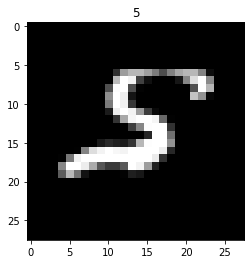

In [7]:
idx = 1
image, label = trainset[idx]

print(f'shape of image : {image.shape}')

print(f'For visualization we need (h x w x c) so using permute shape will be : {image.permute(1, 2, 0).shape}')

plt.imshow(image.permute(1, 2, 0), cmap = 'gray')
plt.title(label);

# Load Dataset into batches

In [8]:
from torch.utils.data import DataLoader

In [11]:
bs = 64

trainloader = DataLoader(trainset, batch_size = bs, shuffle = True)
validloader = DataLoader(validset, batch_size = bs)
testloader = DataLoader(testset, batch_size = bs)

In [12]:
print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')
print(f'Total no. of batches in testloader : {len(testloader)}')

Total no. of batches in trainloader : 782
Total no. of batches in validloader : 157
Total no. of batches in testloader : 157


In [14]:
for images, labels in trainloader:
    print(f"One images batch shape : {images.shape}")
    print(f"One labels batch shape : {labels.shape}")
    break

One images batch shape : torch.Size([64, 1, 28, 28])
One labels batch shape : torch.Size([64])


# Load Model 

In [17]:
from models import DigitModel

model = DigitModel()
model.to(device)

DigitModel(
  (cnn_block): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_featu

# Create Train and Eval Function

In [19]:
def train_fn(model, dataloader, criterion, optimizer):
    
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    
    for images, labels in tqdm(dataloader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += utils.multiclass_accuracy(logits, labels)
        
    return total_loss / len(dataloader), total_acc / len(dataloader)

In [21]:
def eval_fn(model, dataloader, criterion):
    
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    
    with torch.no_grad():

        for images, labels in tqdm(dataloader):

            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            total_acc += utils.multiclass_accuracy(logits, labels)

        return total_loss / len(dataloader), total_acc / len(dataloader)

# Training Loop 

In [22]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)

In [23]:
best_valid_loss = np.Inf

for i in range(7):
    
    train_loss, train_acc = train_fn(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = eval_fn(model, trainloader, criterion)
    
    print(f"Epoch {i+1} Train Loss : {train_loss} Train Acc : {train_acc}")
    print(f"Epoch {i+1} Valid Loss : {valid_loss} Train Acc : {valid_acc}")
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_weights.pt')
        print("SAVED-BEST-MODEL")
        best_valid_loss = valid_loss

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1 Train Loss : 0.6988556572162282 Train Acc : 0.7644461393356323
Epoch 1 Valid Loss : 0.31611087152262785 Train Acc : 0.9003956317901611
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2 Train Loss : 0.3426956108406834 Train Acc : 0.8962196111679077
Epoch 2 Valid Loss : 0.1508086661277029 Train Acc : 0.956182062625885
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3 Train Loss : 0.2683096876715684 Train Acc : 0.9196571111679077
Epoch 3 Valid Loss : 0.13458014427519896 Train Acc : 0.9598785042762756
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4 Train Loss : 0.23872063910621968 Train Acc : 0.9273896813392639
Epoch 4 Valid Loss : 0.12753417870015515 Train Acc : 0.9625359773635864
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5 Train Loss : 0.21810253642385116 Train Acc : 0.935322105884552
Epoch 5 Valid Loss : 0.11958806304608846 Train Acc : 0.9635749459266663
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6 Train Loss : 0.20610821695850634 Train Acc : 0.9384990334510803
Epoch 6 Valid Loss : 0.10998612094927779 Train Acc : 0.9670316576957703
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7 Train Loss : 0.18809474374660673 Train Acc : 0.9447730183601379
Epoch 7 Valid Loss : 0.0971321809317564 Train Acc : 0.9697490334510803
SAVED-BEST-MODEL


# Inference

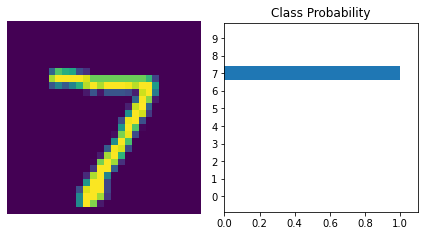

In [24]:
image, label = testset[0]

weights = torch.load('best_weights.pt')
model.load_state_dict(weights)

model.eval()
with torch.no_grad():
    logits = model(image.unsqueeze(0)) # (c, h, w) -> (1, c, h, w)
    ps = torch.nn.Softmax(dim = 1)(logits)[0]
    utils.view_classify(image, ps)